* PAPER - SCAN: Learning to Classify Images without Labels - [[PDF](https://arxiv.org/pdf/2005.12320.pdf)]
    - Self-supervised visual representation learning of images, in which we use the simCLR technique.
    - Clustering of the learned visual representation vectors to maximize the agreement between the cluster assignments of neighboring vectors.

---
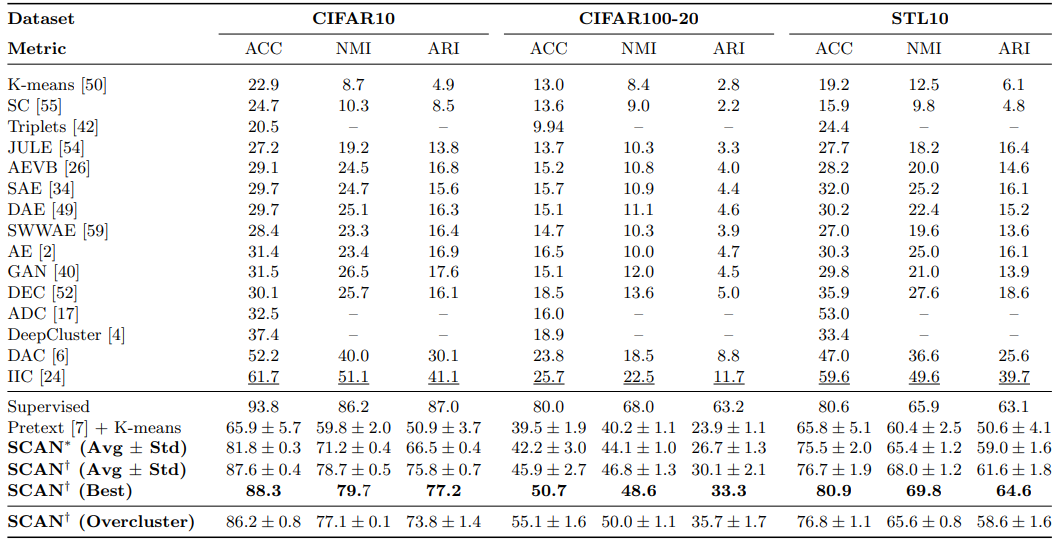

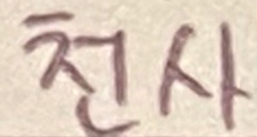

---
`What is Self-Supervised Learning?`
* PAPER - Unsupervised Feature Learning via Non-Parametric Instance-level Discrimination(NPID) - [[PDA](https://arxiv.org/pdf/1805.01978.pdf)] 
* PAPER - Momentum Contrast for Unsupervised Visual Representation Learning(MOCO) - [[PDA](https://arxiv.org/pdf/1911.05722.pdf)] 
* PAPER - Self-Supervised Learning of Pretext-Invariant Representations - [[PDA](https://arxiv.org/pdf/1912.01991.pdf)] 
<br>
=> 기존의 훈련에서는 많은 양의 labeling 된 데이터가 필요합니다. 하지만 labeling 작업이 되어있지 않은 데이터에 대해 이미지를

# 준비

## 라이브러리

In [1]:
from collections import defaultdict
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

tf.get_logger().setLevel('ERROR')

## 데이터

In [2]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test])

print("x_data shape:", x_data.shape, "- y_data shape:", y_data.shape)

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

x_data shape: (60000, 32, 32, 3) - y_data shape: (60000, 1)


In [94]:
train_ds = tf.data.Dataset.from_tensor_slices(x_data).batch(256).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## 하이퍼 파라미터

In [3]:
class config():
    def __init__(self):
        self.target_size = 32  # Resize the input images.
        self.representation_dim = 256  # The dimensions of the features vector.
        self.projection_units = 128  # The projection head of the representation learner.
        self.num_clusters = 20  # Number of clusters.
        self.k_neighbours = 5  # Number of neighbours to consider during cluster learning.
        self.tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.
        
config = config()

## 데이터 전처리

In [4]:
data_preprocessing = keras.Sequential(
    [
        layers.Resizing(config.target_size, config.target_size),
        layers.Normalization(),
    ]
)
# Compute the mean and the variance from the data for normalization.
data_preprocessing.layers[-1].adapt(x_data)

## 증강

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"), # 이미지 이동
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(factor=0.15, fill_mode="nearest"),
        layers.RandomZoom(height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"),
    ]
)

# Self-Supervised Learning

## Vision encoder

In [6]:
def create_encoder(representation_dim):
    encoder = keras.Sequential(
        [
            keras.applications.ResNet50V2(include_top=False, weights=None, pooling="avg"),
            layers.Dense(representation_dim),
        ]
    )
    return encoder

## unsupervised contrastive loss

In [7]:
a= [[1,2,3,4],[4,5,6,7],[7,8,9,1],[1,2,3,4]]
list(zip(*a[::-1]))

[(1, 7, 4, 1), (2, 8, 5, 2), (3, 9, 6, 3), (4, 1, 7, 4)]

In [8]:
## compute_contrastive_loss 를 만드는 과정
## [x,x]=1 일때가 target, y_true
feature_vectors = np.arange(128)
batch_size = 16
num_augmentations = 128//16

tmp = tf.constant(feature_vectors,dtype="float32"); print("tmp.shape : ", tmp.shape)
tmp = tf.expand_dims(tmp, 1); print("tmp.shape - expand_dims : ", tmp.shape)
tmp = tf.math.l2_normalize(tmp); print("tmp.shape - normalize : ", tmp.shape)
logit = tf.linalg.matmul(tmp, tmp, transpose_b=True); print("logit.shape : ", logit.shape)
logit_max = tf.math.reduce_max(logit, axis=1); print("logit_max.shape : ", logit_max.shape)
logit = logit - logit_max
logit = tf.linalg.matmul(tmp, tmp, transpose_b=True); print("logit.shape - logit-logit_max : ", logit.shape)
targets = tf.tile(tf.eye(batch_size), [num_augmentations, num_augmentations]); print("targets.shape : ", targets.shape)

tmp.shape :  (128,)
tmp.shape - expand_dims :  (128, 1)
tmp.shape - normalize :  (128, 1)
logit.shape :  (128, 128)
logit_max.shape :  (128,)
logit.shape - logit-logit_max :  (128, 128)
targets.shape :  (128, 128)


In [9]:
class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units,
        num_augmentations,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=False,
        **kwargs
    ):
        super(RepresentationLearner, self).__init__(**kwargs)
        self.encoder = encoder
        
        # projection head
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):

        num_augmentations = tf.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = tf.math.l2_normalize(feature_vectors, -1)
        
        logits = (tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)/ self.temperature)
        logits_max = tf.math.reduce_max(logits, axis=1)
        logits = logits - logits_max
        targets = tf.tile(tf.eye(batch_size), [num_augmentations, num_augmentations])
        
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )# Compute cross entropy loss

    def call(self, inputs):
        
        preprocessed = data_preprocessing(inputs) # preprocess

        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(preprocessed))
        augmented = layers.Concatenate(axis=0)(augmented) # augmentation concatenate
        
        features = self.encoder(augmented) # feature vector(512,)
        # Apply projection head.
        return self.projector(features) #(128,)

    def train_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        # Run the forward pass and compute the contrastive loss
        
        with tf.device("GPU:0"):
            with tf.GradientTape() as tape:
                feature_vectors = self(inputs, training=True)  # self(inputs) -> feature_vector 
                loss = self.compute_contrastive_loss(feature_vectors, batch_size)  # loss 계산

            # Compute gradients
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)

            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))

            # Update loss tracker metric
            self.loss_tracker.update_state(loss)
        
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

### train

In [ ]:
# Create encoder block
encoder = create_encoder(config.representation_dim)

# Create representation learner.
representation_learner = RepresentationLearner( encoder, config.projection_units, num_augmentations=2, temperature=0.1)

# Create a a Cosine decay learning rate scheduler.
lr_scheduler = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=500, alpha=0.1)
# Compile the model.
representation_learner.compile(optimizer=tfa.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),)
# Fit the model.

history = representation_learner.fit(
    x=train_ds,
    epochs=50,  # for better results, increase the number of epochs to 500.
)

Epoch 1/50
 24/235 [==>...........................] - ETA: 31:16 - loss: 105.0151